In [2]:
from fastai.tabular.all import *
from fastai.tabular import *
from fastai import *
from fastai.test_utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from datetime import datetime
# from IPython.core.display import display, HTML
import seaborn as sns

# display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

dep_var = 'Label'
cat_names = ['Dst Port', 'Protocol']
cont_names = ['Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
              'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
              'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
              'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
              'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
              'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
              'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
              'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
              'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
              'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
              'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
              'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
              'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
              'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
              'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
              'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
              'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
              'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
              'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
              'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
              'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

dataPath = 'data' 
resultPath = 'results'
imagePath = 'images/'
procs = [FillMissing, Categorify, Normalize]

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot([x * 100 for x in metrics[:, i]], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.savefig(imagePath+ 'training_recorder_image.png')
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 10
    figure_height = len(class_names) + 3
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.savefig(imagePath + 'clas_report.png')
    plt.show()

def load(fileName):
    dataFile = os.path.join(dataPath, fileName)
    df = pd.read_csv(dataFile)
    df = df.dropna()
    df = shuffle(df)

    return df

def get_dls(df, path, bs, valid_idx=None):
    return TabularDataLoaders.from_df(
        df = df,
        path=path,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=dep_var,
        valid_idx=valid_idx,
        bs=bs,
        val_bs=bs
    )

In [70]:
def run(dataFile, epochs=10):
    seed = 7
    np.random.seed(seed)
    data = load(dataFile)
    lr = 1e-2
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    fold = 1
    for train_idx, test_idx in kfold.split(data.index, data[dep_var]):
        print('running fold = ', fold)
        fold += 1

        train_data = data.iloc[data.index.intersection(train_idx)].reset_index(drop=True)
        test_data = data.iloc[data.index.intersection(test_idx)].reset_index(drop=True)
        new_data = pd.concat([train_data, test_data])
        
        logfile = 'logs/train_'  + dataFile + '_fold_' + str(fold) + '.log'
        bs = 1000
        dls = get_dls(new_data, path=dataPath, bs=bs, valid_idx=test_data.index)
        
        model = tabular_learner(
            dls, 
            layers=[200, 100],
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy, error_rate, Precision(average='micro'), F1Score(average='micro')],
            cbs=[CSVLogger(logfile, True), ShowGraphCallback()]
        )

        model.fit(epochs, lr)
        model.save('{}.model'.format(os.path.basename(dataFile)))

        model.recorder.plot_metrics()

        le = LabelEncoder()
        y_true = le.fit_transform(test_data.Label)

        time_before_predict = datetime.now()
        preds, targs = model.get_preds()
        time_after_predict = datetime.now()
        
        y_pred = np.argmax(preds, axis=1)
        print("Time predict:")
        print(time_after_predict - time_before_predict)
        
        y_pred = np.array(y_pred)
        class_report = classification_report(y_true, y_pred, target_names=le.classes_)
        plot_classification_report(class_report)
        
        cnf_matrix = confusion_matrix(y_true, y_pred)
        print('Confusion matrix:')
        print(cnf_matrix)
        
        lb = ['Benign', 'Webshell']
        # Plot non-normalized confusion matrix
        class_names = le.classes_
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
        plt.savefig(imagePath + '_fold_' + str(fold) + 'confusion_without_normalization.png')

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
        plt.savefig(imagePath + '_fold_' + str(fold) +  'confusion_with_normalization.png')
        plt.show()
        plt.close()

running fold =  1


epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,f1_score,time
0,0.003987,0.004566,0.999653,0.000347,0.999653,0.999653,00:20
1,0.000748,0.032838,0.999760,0.000240,0.999760,0.999760,00:17
2,0.000617,0.009539,0.999760,0.000240,0.999760,0.999760,00:17
3,0.000487,0.005544,0.999867,0.000133,0.999867,0.999867,00:17
4,0.000156,0.004204,0.999840,0.000160,0.999840,0.999840,00:17
5,0.000301,0.005449,0.999813,0.000187,0.999813,0.999813,00:16
6,0.000187,0.002221,0.999893,0.000107,0.999893,0.999893,00:17
7,0.000352,0.198252,0.999893,0.000107,0.999893,0.999893,00:17
8,0.000031,0.005595,0.999947,0.000053,0.999947,0.999947,00:17
9,0.000002,0.002806,0.999947,0.000053,0.999947,0.999947,00:17


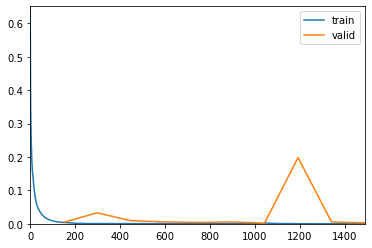

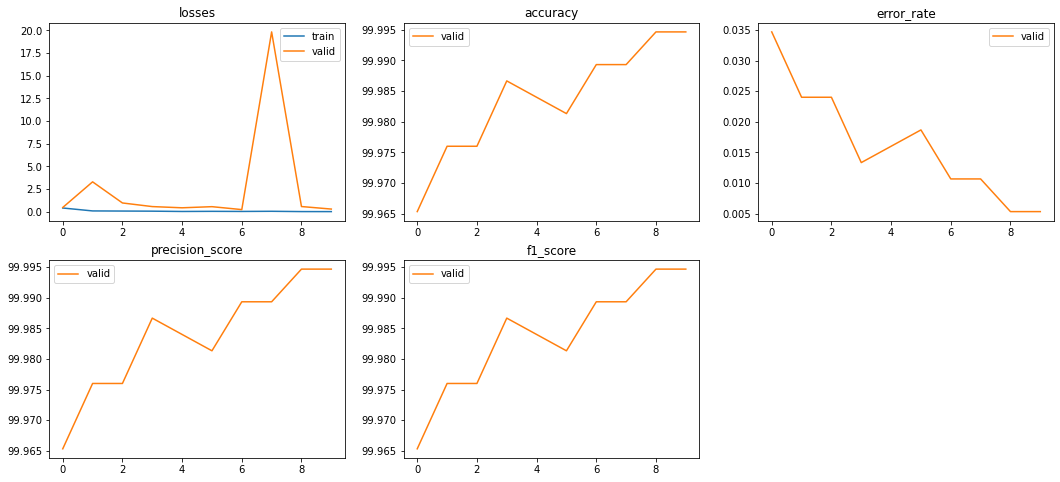

Time predict:
0:00:00.749434


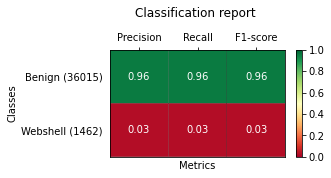

Confusion matrix:
[[34624  1391]
 [ 1418    44]]


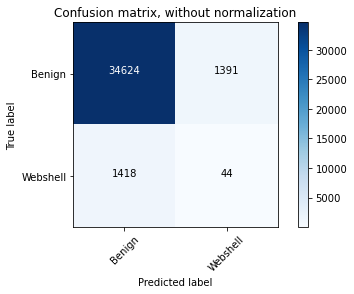

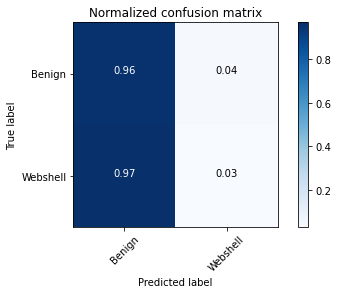

running fold =  2


epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,f1_score,time
0,0.004988,0.003113,0.999787,0.000213,0.999787,0.999787,00:17
1,0.001850,0.004792,0.999813,0.000187,0.999813,0.999813,00:16
2,0.000443,0.006250,0.999867,0.000133,0.999867,0.999867,00:19
3,0.000155,0.005709,0.999840,0.000160,0.999840,0.999840,00:16
4,0.000235,0.003190,0.999813,0.000187,0.999813,0.999813,00:16
5,0.000075,0.002879,0.999813,0.000187,0.999813,0.999813,00:16
6,0.000083,0.007247,0.999893,0.000107,0.999893,0.999893,00:18
7,0.000068,0.035825,0.999707,0.000294,0.999706,0.999706,00:19
8,0.000661,0.012810,0.999787,0.000213,0.999787,0.999787,00:19
9,0.005429,0.030480,0.999813,0.000187,0.999813,0.999813,00:19


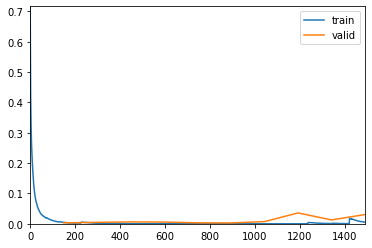

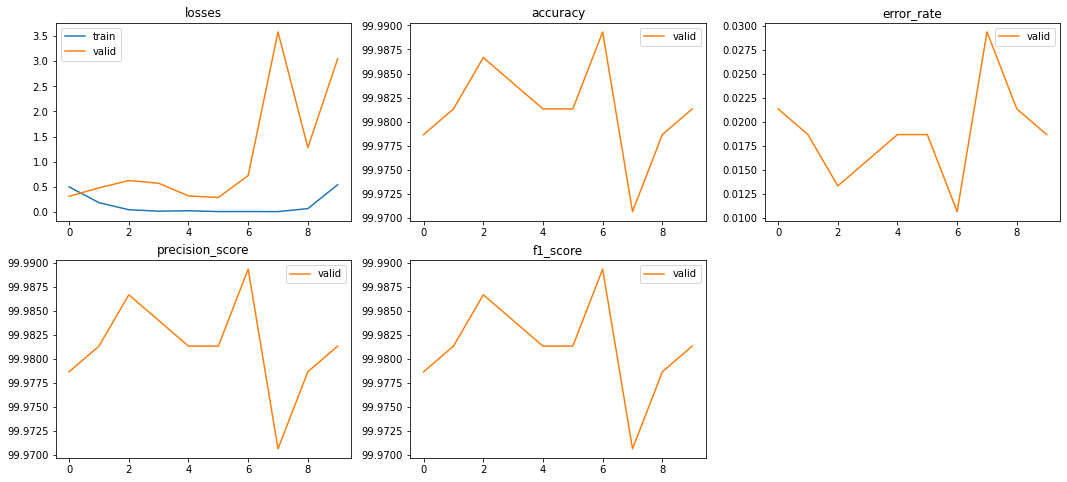

Time predict:
0:00:00.875058


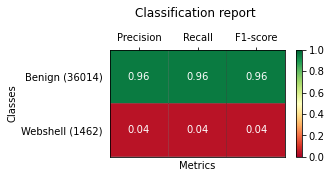

Confusion matrix:
[[34606  1408]
 [ 1403    59]]


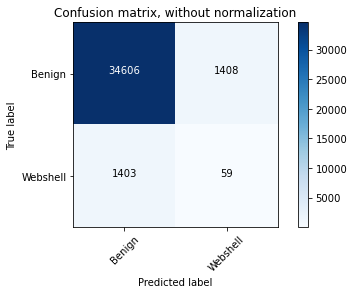

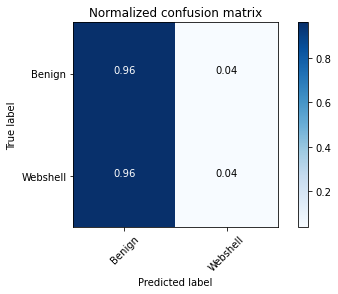

running fold =  3


epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,f1_score,time
0,0.005834,0.003572,0.999840,0.000160,0.999840,0.999840,00:16
1,0.000952,0.001140,0.999760,0.000240,0.999760,0.999760,00:16
2,0.009157,0.008468,0.999786,0.000213,0.999787,0.999787,00:16
3,0.000769,0.003070,0.999893,0.000107,0.999893,0.999893,00:16
4,0.000224,0.031440,0.999920,0.000080,0.999920,0.999920,00:16
5,0.000141,0.003076,0.999893,0.000107,0.999893,0.999893,00:16
6,0.000452,0.000630,0.999920,0.000080,0.999920,0.999920,00:16
7,0.000959,0.006096,0.999920,0.000080,0.999920,0.999920,00:16
8,0.000051,0.001307,0.999947,0.000053,0.999947,0.999947,00:16
9,0.000003,0.003265,0.999947,0.000053,0.999947,0.999947,00:16


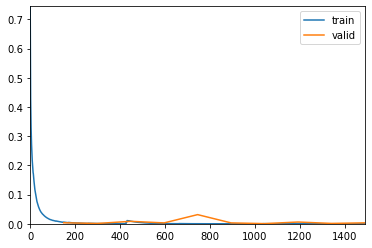

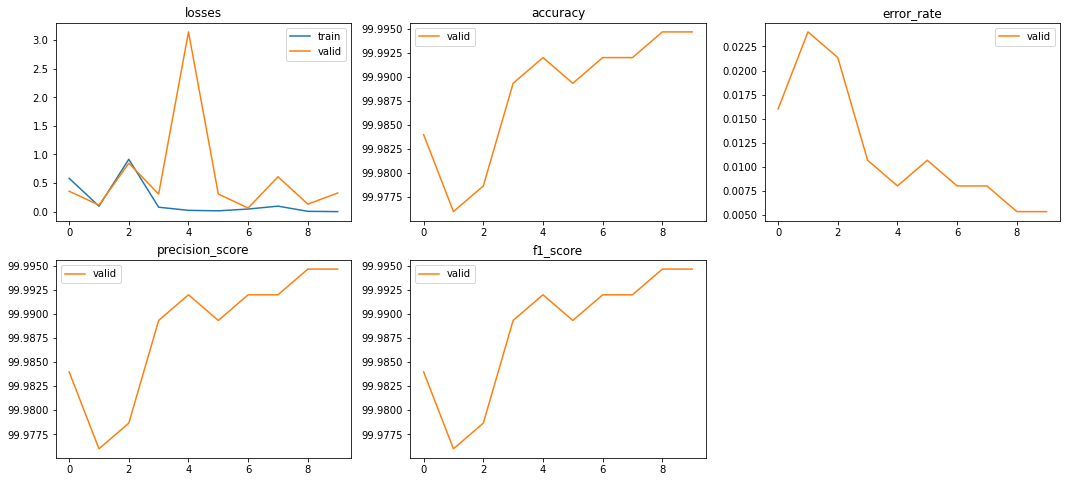

Time predict:
0:00:00.691247


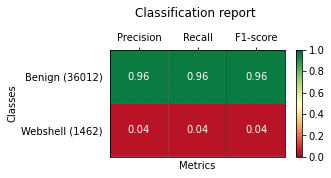

Confusion matrix:
[[34619  1393]
 [ 1407    55]]


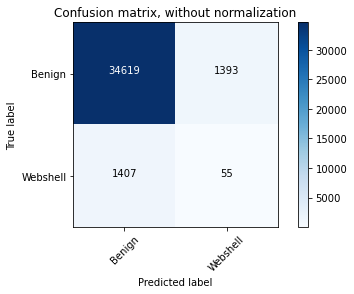

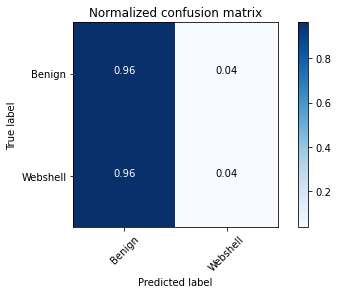

running fold =  4


epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,f1_score,time
0,0.006731,0.150685,0.999733,0.000267,0.999733,0.999733,00:16
1,0.001418,0.021608,0.999733,0.000267,0.999733,0.999733,00:15
2,0.000523,0.004097,0.999867,0.000133,0.999867,0.999867,00:16
3,0.000818,0.006865,0.999787,0.000213,0.999787,0.999787,00:15
4,0.000566,0.004781,0.999920,0.000080,0.999920,0.999920,00:16
5,0.000641,0.342882,0.999787,0.000213,0.999787,0.999787,00:16
6,0.000080,0.003535,0.999920,0.000080,0.999920,0.999920,00:16
7,0.000023,0.001250,0.999920,0.000080,0.999920,0.999920,00:16
8,0.000008,0.007618,0.999947,0.000053,0.999947,0.999947,00:16
9,0.000518,0.020204,0.999867,0.000133,0.999867,0.999867,00:16


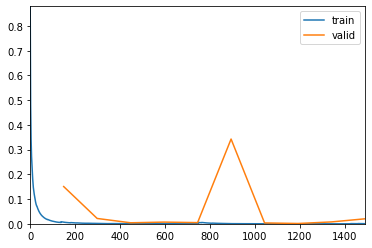

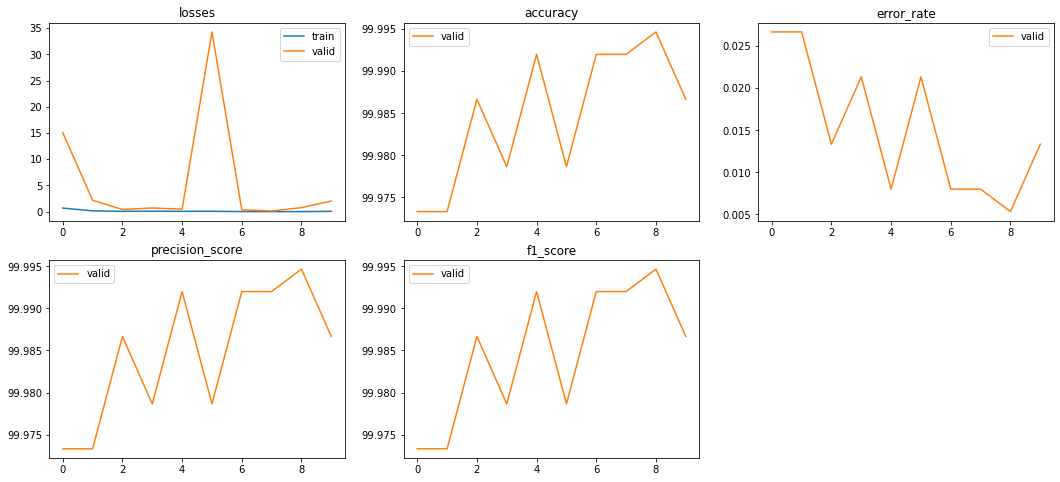

Time predict:
0:00:00.732113


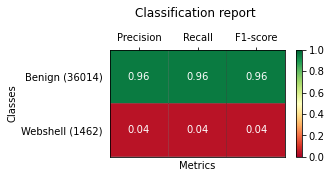

Confusion matrix:
[[34656  1358]
 [ 1399    63]]


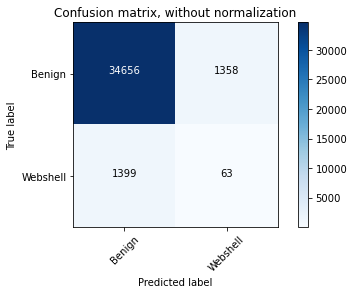

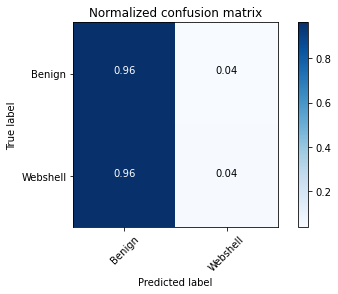

running fold =  5


epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,f1_score,time
0,0.004006,0.028196,0.999680,0.000320,0.999680,0.999680,00:16
1,0.003113,0.003796,0.999867,0.000133,0.999867,0.999867,00:16
2,0.000300,0.006855,0.999733,0.000267,0.999733,0.999733,00:16
3,0.000378,0.001301,0.999867,0.000133,0.999867,0.999867,00:16
4,0.000155,0.005431,0.999840,0.000160,0.999840,0.999840,00:16
5,0.000495,0.014386,0.999813,0.000187,0.999813,0.999813,00:16
6,0.000083,0.008640,0.999893,0.000107,0.999893,0.999893,00:16
7,0.000027,0.006699,0.999867,0.000133,0.999867,0.999867,00:16
8,0.000569,0.003303,0.999893,0.000107,0.999893,0.999893,00:16
9,0.000081,0.013986,0.999840,0.000160,0.999840,0.999840,00:17


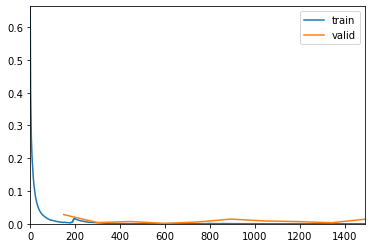

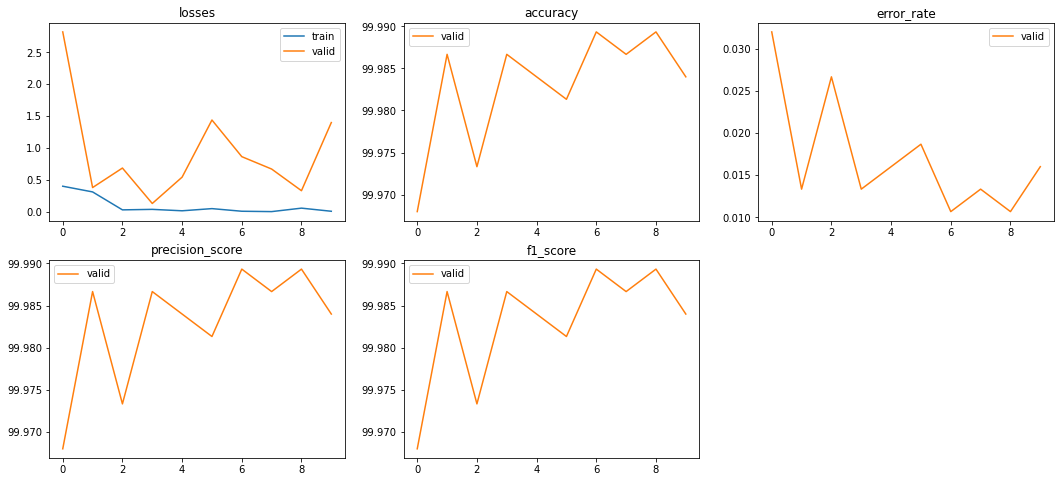

Time predict:
0:00:00.829243


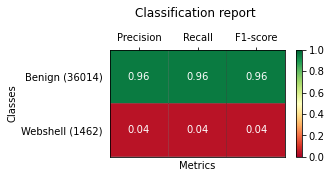

Confusion matrix:
[[34638  1376]
 [ 1405    57]]


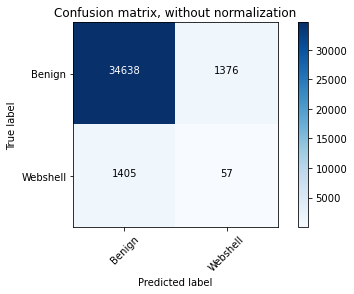

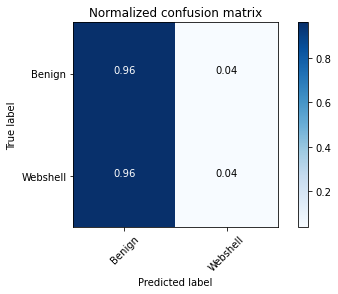

In [71]:
run('webshell_binary_file2.csv')